In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [3]:
# engle-granger test for cointegration
def EG_method(X,Y,show_summary=False):
    
    # step 1
    # estimate long run equilibrium
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid
    
    if show_summary:
        print('\nStep 1\n')
        print(model1.summary())
    
    '''
    checks the p-value of augmented dickey-fuller tests
    ADF basically tests the null hypothesis that a unit root is present here
    if p-value is less than 5%, the stationary test is passed
    '''
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    # take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    # step 2
    '''
    estimates error correction model
    because the cointegrating vector is unknown, we use OLS to estimate it
    '''
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    if show_summary:
        print('\nStep 2\n')
        print(model2.summary())
    
    # adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1

In [4]:
# verify cointegration by checking historical datasets yippeeeeee
# check signals - we long the bearish one and short the bullish one
def signal_generation(asset1,asset2,method,bandwidth=250):    
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    # signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    # initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    
    # signal processing
    for i in range(bandwidth,len(signals)):
        
        # cointegration test
        coint_status,model=method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        # cointegration breaks
        # clear any existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        # cointegration starts
        # set the trigger conditions to minimize calculations
        if not prev_status and coint_status:
            
            # predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            # normalize the residual to get z stat
            # z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            # create thresholds
            # conventionally one sigma is the threshold
            # two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)
        
        # as z stat cannot exceed both upper and lower bounds at the same time
        # the lines below hold
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=1            
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=-1
                
        prev_status=coint_status    
    
    # take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    # only need to generate trading signal of one asset
    # logically, the other one should be the opposite direction :)
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals

In [5]:
# stuff for position visualization, not particularly interesting
def plot(data,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    # show the two different assets
    asset1_price,=bx.plot(data.index,data['asset1'],
                          c='#113aac',alpha=0.7)
    asset2_price,=bx2.plot(data.index,data['asset2'],
                          c='#907163',alpha=0.7)

    # visualize positions
    asset1_long,=bx.plot(data.loc[data['positions1']==1].index,
                data['asset1'][data['positions1']==1],
                lw=0,marker='^',markersize=8,
                c='g',alpha=0.7)
    asset1_short,=bx.plot(data.loc[data['positions1']==-1].index,
                data['asset1'][data['positions1']==-1],
                lw=0,marker='v',markersize=8,
                c='r',alpha=0.7)
    asset2_long,=bx2.plot(data.loc[data['positions2']==1].index,
                 data['asset2'][data['positions2']==1],
                 lw=0,marker='^',markersize=8,
                 c='g',alpha=0.7)
    asset2_short,=bx2.plot(data.loc[data['positions2']==-1].index,
                 data['asset2'][data['positions2']==-1],
                 lw=0,marker='v',markersize=8,
                 c='r',alpha=0.7)

    # labels
    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([asset1_price,asset2_price,asset1_long,asset1_short],
               [ticker1,ticker2,
               'LONG','SHORT'],
               loc='lower left')

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

In [6]:
# visualize overall portfolio performance
def portfolio(data):

    # initial capital to calculate the actual pnl
    capital0=20000

    # shares to buy of each position
    # this is no forward bias
    # just ensure we have enough $$$ to purchase shares when the price peaks
    positions1=capital0//max(data['asset1'])
    positions2=capital0//max(data['asset2'])

    # create cumsum1 to check the holding of the position
    data['cumsum1']=data['positions1'].cumsum()

    # since there are two assets, we need to calculate each asset separately
    # then aggregate them into one portfolio
    portfolio=pd.DataFrame()
    portfolio['asset1']=data['asset1']
    portfolio['holdings1']=data['cumsum1']*data['asset1']*positions1
    portfolio['cash1']=capital0-(data['positions1']*data['asset1']*positions1).cumsum()
    portfolio['total asset1']=portfolio['holdings1']+portfolio['cash1']
    portfolio['return1']=portfolio['total asset1'].pct_change()
    portfolio['positions1']=data['positions1']
    
    # same thing, now for asset 2
    data['cumsum2']=data['positions2'].cumsum()
    portfolio['asset2']=data['asset2']
    portfolio['holdings2']=data['cumsum2']*data['asset2']*positions2
    portfolio['cash2']=capital0-(data['positions2']*data['asset2']*positions2).cumsum()
    portfolio['total asset2']=portfolio['holdings2']+portfolio['cash2']
    portfolio['return2']=portfolio['total asset2'].pct_change()
    portfolio['positions2']=data['positions2']
 
    portfolio['z']=data['z']
    portfolio['total asset']=portfolio['total asset1']+portfolio['total asset2']
    portfolio['z upper limit']=data['z upper limit']
    portfolio['z lower limit']=data['z lower limit']
    
    # plotting the asset value change of the portfolio
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
 
    total_asset_performance,=ax.plot(portfolio['total asset'],c='#46344e')
    z_stats,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
 
    threshold=ax2.fill_between(portfolio.index,portfolio['z upper limit'],
                       portfolio['z lower limit'],
                       alpha=0.2,color='#ffb48f')
     
    # not plotting positions on asset performance bc of the opposite trade directions
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    
    plt.legend([z_stats,threshold,total_asset_performance],
               ['Z Statistics', 'Z Statistics +-1 Sigma',
                'Total Asset Performance'],loc='best')

    plt.grid(True)   
    plt.title('Total Asset')
    plt.show()

    return portfolio

In [13]:
# bring everything together
def main():
    
    # the sample i am using are NVDA and AMD from 2013 to 2014
    # play around with what you choose, go crazy
    stdate='2013-01-01'
    eddate='2014-12-31'
    ticker1='NVDA'
    ticker2='AMD'

    #extract data
    asset1=yf.download(ticker1,start=stdate,end=eddate)
    asset2=yf.download(ticker2,start=stdate,end=eddate)  

    #create signals
    signals=signal_generation(asset1,asset2,EG_method)

    # only visualize the part where trading signals occur
    ind=signals['z'].dropna().index[0]

    # visualize positions
    plot(signals[ind:],ticker1,ticker2)    

    # visualize portfolio performance
    portfolio_details=portfolio(signals[ind:])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_3844/3095413883.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_3844/3095413883.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_3844

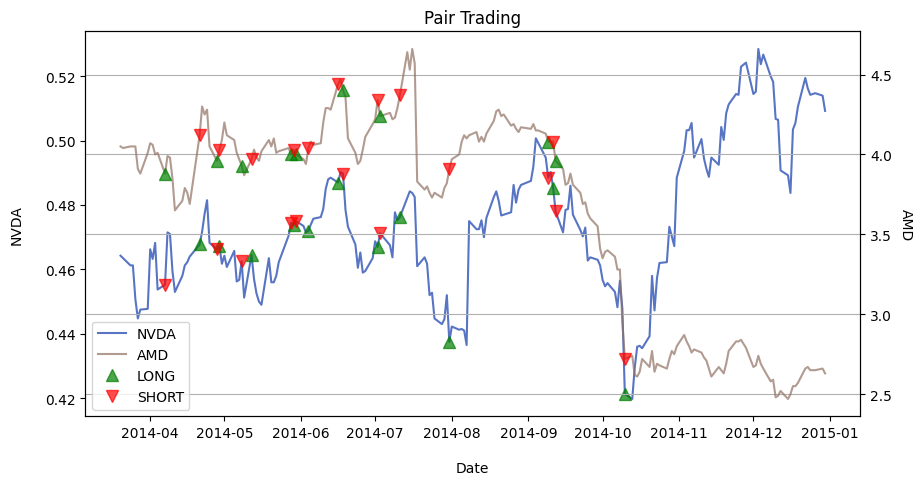

/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_3844/2656492372.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumsum1']=data['positions1'].cumsum()
/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_3844/2656492372.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumsum2']=data['positions2'].cumsum()


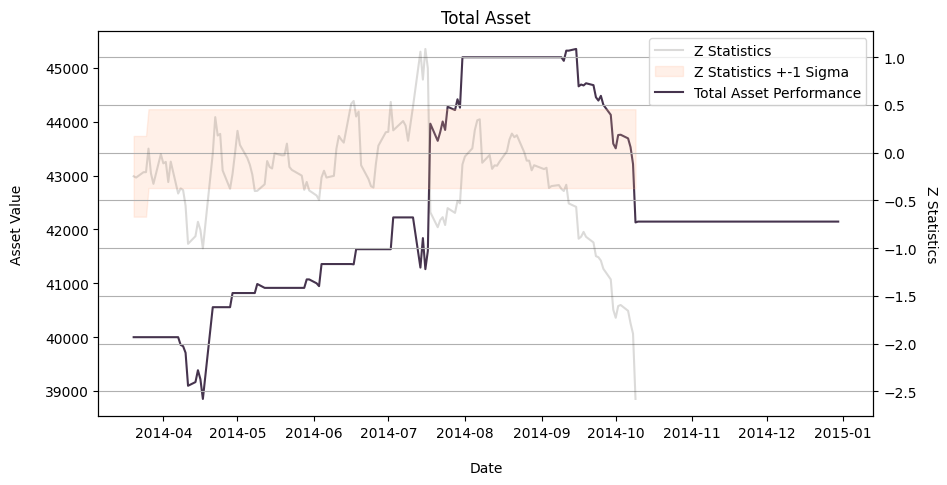

In [14]:
# lots of scrolling past the notes about pandas documentation caveats
# sorry if you're actually running this haha

if __name__ == '__main__':
    main()